In [1]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [5]:
data = 'augmented data'
No_brain_tumor = r'augmented data\no'
Yes_brain_tumor = r'augmented data\yes'

In [6]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  2064    labels:  2064


In [8]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(2064,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,augmented data\no\aug_1 no._0_1264.jpg,No
1,augmented data\no\aug_1 no._0_2241.jpg,No
2,augmented data\no\aug_1 no._0_2364.jpg,No
3,augmented data\no\aug_1 no._0_340.jpg,No
4,augmented data\no\aug_1 no._0_3461.jpg,No


In [9]:

print(df['labels'].value_counts())

labels
Yes    1085
No      979
Name: count, dtype: int64


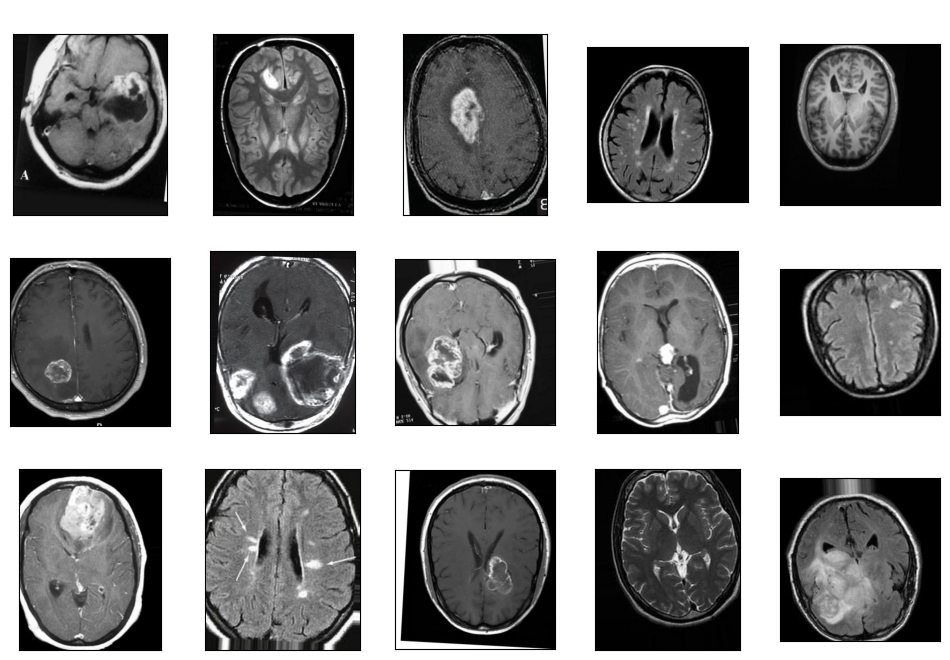

In [10]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (1764, 2)
test set shape: (104, 2)
validation set shape: (196, 2)


In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [13]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 1764 validated image filenames belonging to 2 classes.
Found 196 validated image filenames belonging to 2 classes.
Found 104 validated image filenames belonging to 2 classes.


In [14]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [15]:

from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 60s 1us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.0

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
56/56 [==============================] - 60s 1s/step - loss: 0.4862 - accuracy: 0.7857 - val_loss: 0.4554 - val_accuracy: 0.8163
Epoch 2/100
56/56 [==============================] - 58s 1s/step - loss: 0.4656 - accuracy: 0.7823 - val_loss: 0.4270 - val_accuracy: 0.8112
Epoch 3/100
56/56 [==============================] - 58s 1s/step - loss: 0.4590 - accuracy: 0.7942 - val_loss: 0.4106 - val_accuracy: 0.8520
Epoch 4/100
56/56 [==============================] - 58s 1s/step - loss: 0.4251 - accuracy: 0.8095 - val_loss: 0.3989 - val_accuracy: 0.8163
Epoch 5/100
56/56 [==============================] - 60s 1s/step - loss: 0.4144 - accuracy: 0.8316 - val_loss: 0.3961 - val_accuracy: 0.8214
Epoch 6/100
56/56 [==============================] - 61s 1s/step - loss: 0.4030 - accuracy: 0.8237 - val_loss: 0.3917 - val_accuracy: 0.8214
Epoch 7/100
56/56 [==============================] - 59s 1s/step - loss: 0.3926 - accuracy: 0.8390 - val_loss: 0.4016 - val_accuracy: 0.8112
Epoch 8/100
5

In [18]:
model.save("Tumor_classifier_model.h5")

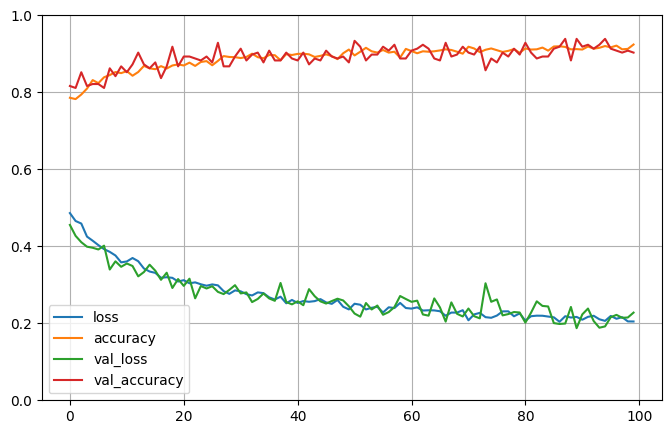

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [27]:
from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread(r"no\11 no.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
    print("Yes")
else:
    print("no")
# result = pred.argmax()
# result

1/1 [==============================] - 1s 590ms/step
no
